In [1]:
#https://tuanatran.medium.com/fine-tuning-large-language-model-with-hugging-face-pytorch-adce80dce2ad

In [1]:
from transformers import GPT2TokenizerFast, GPT2Config, GPT2LMHeadModel
from transformers import get_linear_schedule_with_warmup

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split, RandomSampler, SequentialSampler

import pandas as pd
import os
from tqdm import tqdm

In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [ ]:
#Define the model to use

# model_name: ['gpt2', 'google-bert/bert-base-german-cased', 'dmis-lab/biobert-v1.1', 'google/flan-t5-base']
model_name = "gpt2" 
path = os.path.dirname(os.getcwd()) + "\\Text_Generation\\Models\\pretrained_gpt2_v2"
model_save_path = path

In [5]:
data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'cleaned.csv')

In [ ]:
data_path

In [ ]:
# Add sos and eos tokens to the strings

df = pd.read_csv(data_path)
df.reset_index(drop=True, inplace=True)

def form_string(operation):
    s = f"<|startoftext|>{operation.strip()}<|endoftext|>" 
    return s

data = df.apply(lambda x:form_string(x['Operation']), axis=1).to_list()
data[0]

In [ ]:
# initialize the tokenizer

tokenizer = GPT2TokenizerFast.from_pretrained(model_name,
                                            bos_token='<|startoftext|>',
                                            eos_token='<|endoftext|>',
                                            unk_token='<|unknown|>',
                                            pad_token='<|pad|>'
                                            )

In [ ]:
#Dataset class for training, turns tokenizes input strings 

class SurgicalReportDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.input_ids = []
        self.attn_masks = []

        for opbericht in data:
            encodings = tokenizer.encode_plus(opbericht,
                                              truncation=True,
                                              padding='max_length',
                                              max_length = 1024,
                                              return_tensors='pt'       
                                             )
            self.input_ids.append(torch.squeeze(encodings['input_ids'],0))
            self.attn_masks.append(torch.squeeze(encodings['attention_mask'],0))


    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.input_ids[idx], self.attn_masks[idx]

In [10]:
batch_size = 4

dataset = SurgicalReportDataset(data, tokenizer)

In [ ]:
# Initialize train eval split

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
)

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [ ]:
# Load model and initialize training parameters

configuration = GPT2Config.from_pretrained(model_name, is_decoder = True)
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)
model = model.to(device)
model.resize_token_embeddings(len(tokenizer))

epochs = 50
learning_rate = 2e-5
warmup_steps = 1e2

epsilon = 1e-8
optim = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

total_steps = len(train_dataloader) * epochs  


scheduler = get_linear_schedule_with_warmup(optim,
                                            num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps)

In [ ]:
model

In [14]:
eval_loss = {}

In [ ]:
#Trainings Loop

for epoch_i in range(0, epochs):
    total_train_loss = 0
    model.train() 

    for step, batch in tqdm(enumerate(train_dataloader), total= len(train_dataloader), desc="Epoch: [{}]".format(epoch_i)): 
        b_input_ids = batch[0].to(device) 
        b_labels    = batch[0].to(device)
        b_masks     = batch[1].to(device) 

        model.zero_grad()
        outputs = model( input_ids = b_input_ids, labels = b_labels,
                         attention_mask = b_masks, token_type_ids = None )

        loss = outputs[0]
        loss.backward()
        optim.step()
        scheduler.step()
        
    print('Trainings Loss: {:1.4}'.format(loss.item()))
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_labels    = batch[0].to(device)
        b_masks     = batch[1].to(device)

        with torch.no_grad():
            outputs  = model(input_ids = b_input_ids, labels = b_labels,
                             attention_mask = b_masks)
            loss = outputs[0]
    print('Validation Loss: {:1.4}'.format(loss.item()))
    eval_loss[epoch_i] = loss.item()

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)


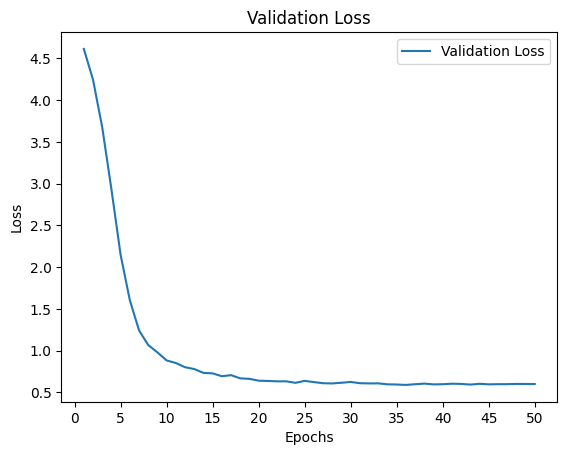

In [21]:
import matplotlib.pyplot as plt
from numpy import arange

# Load the training and validation loss dictionaries
val_loss = eval_loss
 
# Retrieve each dictionary's values
val_values = []

for x in val_loss:
    val_values.append(val_loss[x])
 
y = len(val_values)+1
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, y)
 
# Plot and label the training and validation loss values
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, y, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

Testing:

In [5]:
model_name = os.path.dirname(os.getcwd()) + "\\Text_Generation\\Models\\pretrained_gpt2_v2"
tokenizer = GPT2TokenizerFast.from_pretrained(model_name,
                                              bos_token='<|startoftext|>',
                                              eos_token='<|endoftext|>',
                                              unk_token='<|unknown|>',
                                              pad_token='<|pad|>'
                                             )
configuration = GPT2Config.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, config=configuration)
model = model.to(device)

In [6]:
# Generate a output based on input string, outputs a generated a greedy generated string and a beam generated string.

def infer(prompt):
    input = f"<|startoftext|>{prompt.strip()}"
    input = tokenizer(input, return_tensors="pt")
    input_ids      = input["input_ids"]
    attention_mask = input["attention_mask"]

    output_topk = model.generate(input_ids.to(device),
                            attention_mask=attention_mask.to(device),
                            max_length = 1024,
                            do_sample = True, 
                            top_k = 50, 
                            top_p = 0.85,
                            renormalize_logits = True)
    
    output_beam = model.generate(input_ids.to(device),
                            attention_mask=attention_mask.to(device),
                            max_length = 1024,
                            early_stopping = True,
                            do_sample = True, 
                            top_k = 50, 
                            top_p = 0.85,
                            num_beams = 4,
                            renormalize_logits = True)
    output_topk = tokenizer.decode(output_topk[0], skip_special_tokens=True)
    output_beam = tokenizer.decode(output_beam[0], skip_special_tokens=True)
    return output_topk, output_beam

In [ ]:
top_k = []
beam = []
for i in range(25):
    out_k, out_beam = infer('Ablauf:')
    top_k.append(out_k)
    beam.append(out_beam)

In [ ]:
top_k

In [ ]:
beam

In [11]:
report_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'cleaned.csv')
df = pd.read_csv(report_path)
df.reset_index(drop=True, inplace=True)

In [14]:
#Evaluate the generated reports
import evaluate
import random

rouge = evaluate.load('rouge')



random.seed(99)
references = random.choices(df['Operation'].to_list(), k=25)

candidates = top_k
results = rouge.compute(predictions=candidates, references=references)
print('Greedy: ', results)

candidates = beam
results = rouge.compute(predictions=candidates, references=references)
print('Beam: ', results)

Greedy:  {'rouge1': 0.8138861401328383, 'rouge2': 0.7472317820765302, 'rougeL': 0.777413043138942, 'rougeLsum': 0.7786336654387764}
Beam:  {'rouge1': 0.8140157063504891, 'rouge2': 0.7459408045947378, 'rougeL': 0.777693910201936, 'rougeLsum': 0.7788819558510198}


In [16]:
from sentence_transformers import SentenceTransformer
import torch

model = SentenceTransformer("all-MiniLM-L6-v2")

# Compute embeddings for both lists
embeddings1 = model.encode(references)
embeddings2 = model.encode(top_k)
embeddings3 = model.encode(beam)

# Compute cosine similarities
similarities_greedy = model.similarity(embeddings1, embeddings2)

similarities_beam = model.similarity(embeddings1, embeddings3)

print('Greedy: ', torch.mean(similarities_greedy))

print('Beam: ', torch.mean(similarities_beam))

Greedy:  tensor(0.8028)
Beam:  tensor(0.8018)
